# Addict Recovery Journey Recommender (Transcript)
---

## Approach

1. **Data Processing:** Cleaned and tokenized transcript text, removing stopwords and noise.
2. **Embeddings:** Created custom Word2Vec embeddings to capture semantic meaning of words.
3. **Lift Calculation:** Computed normalized word “lifts” (importance scores) and performed VADER sentiment analysis.
4. **Topic Modeling:** Clustered semantically similar words into topics using KMeans and analyzed each topic’s overall sentiment.
5. **Stage Mapping:** Used SBERT + cosine similarity to map topics to six recovery stages — Denial, Ambivalence, Commitment, Coping, Maintenance, Relapse — ensuring all stages have representation.
6. **Stage Metrics:** Aggregated topic information to compute normalized stage lifts (sum = 1) and average stage sentiment.
7. **Visualization:** Generated side-by-side stage mind-maps (colored by sentiment) and bar charts comparing normalized lifts and sentiment values between the new transcript and the baseline.
8. **Recommender:** The function automatically builds a new stage map from any uploaded transcript, compares it numerically and visually to the baseline, and indicates whether the recovery trajectory aligns or diverges.

> Stage Lift - Time Spent on each stage  
> Stage Sentiment - Positive/Negative sentiment for each stage  
 
**Output:**  
A detailed comparison table + visual mind-maps + bar charts showing each stage’s relative progress and emotional tone.

## Approach

1. **Data Processing:** Cleaned and tokenized transcript text, removing stopwords and noise.
2. **Embeddings:** Created custom Word2Vec embeddings to capture semantic meaning of words.
3. **Lift Calculation:** Computed normalized word “lifts” (importance scores) and performed VADER sentiment analysis.
4. **Topic Modeling:** Clustered semantically similar words into topics using KMeans and analyzed each topic’s overall sentiment.
5. **Stage Mapping:** Used SBERT + cosine similarity to map topics to six recovery stages — Denial, Ambivalence, Commitment, Coping, Maintenance, Relapse — ensuring all stages have representation.
6. **Stage Metrics:** Aggregated topic information to compute normalized stage lifts (sum = 1) and average stage sentiment.
7. **Visualization:** Generated side-by-side stage mind-maps (colored by sentiment) and bar charts comparing normalized lifts and sentiment values between the new transcript and the baseline.
8. **Recommender:** The function automatically builds a new stage map from any uploaded transcript, compares it numerically and visually to the baseline, and indicates whether the recovery trajectory aligns or diverges.

> `Stage Lift` - Time Spent on each stage  
> `Stage Sentiment` - Positive/Negative sentiment for each stage  
 
**OUTPUT:** A detailed `comparison table + visual mind-maps + bar charts` showing each stage’s relative progress and emotional tone.

### 0) Setup

This cell installs and imports all required libraries, loads English stop-words and sentiment lexicons,  
and defines key constants such as file paths, the transcript column name, and the ordered stage list.

It also creates the `results/` folder for saving embeddings, tables, and plots.  
You should run this cell once at the start of the notebook.


In [1]:
# Auto-install missing packages (safe to re-run)
import sys, subprocess, importlib

def pip_install(pkg): 
    if importlib.util.find_spec(pkg) is None:
        print(f"⏳ Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ["pandas", "numpy", "nltk", "gensim", "scikit-learn", "sentence-transformers", "matplotlib"]:
    pip_install(pkg)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# NLTK resources
import nltk
nltk.download("stopwords", quiet=True)
nltk.download("vader_lexicon", quiet=True)
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Gensim Word2Vec
from gensim.models import Word2Vec

# Sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale
from sklearn.metrics.pairwise import cosine_similarity

# Sentence-Transformers (for stage mapping)
from sentence_transformers import SentenceTransformer

# --- Paths & constants ---
CSV_PATH = Path("playlist_transcripts_complete.csv")  # change if needed
TEXT_COL = "transcript_whisper"
MAX_PRINT = 50   # avoid flooding the notebook; full tables are saved to CSV

# Stage ontology (fixed order)
STAGES = ["Denial", "Ambivalence", "Commitment", "Coping", "Maintenance", "Relapse"]

# Seed phrases to represent each stage (used later for cosine similarity)
STAGE_SEEDS = {
    "Denial":       "I do not have a problem and everything is fine.",
    "Ambivalence":  "I want to change but I feel conflicted and uncertain.",
    "Commitment":   "I have decided to seek help and commit to recovery.",
    "Coping":       "I am practicing new strategies and coping skills daily.",
    "Maintenance":  "I maintain healthy habits to prevent relapse long term.",
    "Relapse":      "I slipped back into use but I am trying to recover again."
}

# Set global seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Initialize tools
STOPWORDS = set(stopwords.words("english"))
VADER = SentimentIntensityAnalyzer()

print("✅ Setup complete.")


⏳ Installing scikit-learn ...
⏳ Installing sentence-transformers ...
✅ Setup complete.


## 🔹 WORD-LEVEL ANALYSIS

(from Steps 1–6)

### 1) Import the CSV

Reads the transcript dataset (`playlist_transcripts_complete.csv`) and extracts the  
`transcript_whisper` column. Empty or missing rows are removed.

The resulting DataFrame `df` contains one cleaned transcript per record.


In [2]:
df_raw = pd.read_csv('./Final Dataset/transcript/playlist_transcripts_complete.csv')
assert TEXT_COL in df_raw.columns, f"Column '{TEXT_COL}' not found in {CSV_PATH.name}"
df = df_raw[[TEXT_COL]].rename(columns={TEXT_COL: "text"}).copy()
df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].reset_index(drop=True)

print(f"✅ Loaded CSV with {len(df):,} rows.")
print(df.head(5))


✅ Loaded CSV with 51 rows.
                                                text
0  So I started using drugs when I was 12 years o...
1  you oh we're brothers me being the older broth...
2  I grew up in probably your standard households...
3  My name is Lisa Ann Webb. I am here today to t...
4  I'm here because I want to make a difference. ...


### 2) Remove Stop-Words

Tokenizes each transcript into lowercase alphabetic tokens and removes English stop-words.  
This produces:

- `tokens_per_doc`: list of cleaned tokens for each transcript  
- `all_tokens`: flattened list of all tokens across the corpus  

These will be used to train the Word2Vec embedding model.


In [3]:
import re

def tokenize_clean(text: str):
    # simple word tokenizer: keep alphabetic tokens
    tokens = re.findall(r"[A-Za-z]+", text.lower())
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    return tokens

tokens_per_doc = df["text"].apply(tokenize_clean)
all_tokens = [t for doc in tokens_per_doc for t in doc]

print(f"✅ Tokenization complete. Total tokens (after stop-word removal): {len(all_tokens):,}")
print("Sample tokens from first doc:", tokens_per_doc.iloc[0][:20] if len(tokens_per_doc)>0 else [])


✅ Tokenization complete. Total tokens (after stop-word removal): 54,898
Sample tokens from first doc: ['started', 'using', 'drugs', 'years', 'old', 'really', 'wanted', 'fit', 'everyone', 'know', 'smoking', 'weed', 'drinking', 'lot', 'lsd', 'actually', 'hippie', 'chick', 'going', 'fish']


### 3) Create Custom Word Embeddings

Trains a Word2Vec model on all tokens from the corpus.  
Each vocabulary word receives a 100-dimensional vector capturing its contextual meaning.

Outputs:
- `df_embeddings`: matrix of word vectors  
- Preview printed in the notebook  
- Full table saved to `results/embeddings_word2vec.csv`


In [4]:
OUT_DIR = Path("results"); OUT_DIR.mkdir(exist_ok=True, parents=True)

# Train a small Word2Vec model (skip-gram works well for semantics)
model = Word2Vec(
    sentences=tokens_per_doc.tolist(),
    vector_size=100, window=5, min_count=3, workers=4, sg=1, epochs=10
)

vocab = list(model.wv.key_to_index.keys())
word_vecs = np.vstack([model.wv[w] for w in vocab])
emb_matrix = np.vstack([model.wv[w] for w in vocab])
df_embeddings = pd.DataFrame(emb_matrix, index=vocab)
df_embeddings.index.name = "word"

# Save & print
emb_path = OUT_DIR / "embeddings_word2vec.csv"
df_embeddings.to_csv(emb_path)
print(f"✅ Trained Word2Vec on {len(vocab)} unique words. Saved all embeddings → {emb_path}")

print("\n🔎 Preview of custom word embeddings (first rows):")
print(df_embeddings.head(min(MAX_PRINT, len(df_embeddings))))


✅ Trained Word2Vec on 2260 unique words. Saved all embeddings → results\embeddings_word2vec.csv

🔎 Preview of custom word embeddings (first rows):
                 0         1         2         3         4         5   \
word                                                                    
like      -0.127029 -0.225155  0.174125 -0.022296  0.088857 -0.340686   
know      -0.050090 -0.102848 -0.036281 -0.063980  0.005663 -0.195799   
get        0.119563  0.275526 -0.219083  0.095333  0.267298 -0.254547   
got        0.196348  0.226536 -0.137330  0.051372  0.176189 -0.271124   
going     -0.246186  0.291334 -0.250117 -0.037338  0.198641 -0.032740   
people    -0.163370  0.072191  0.052082  0.040690  0.078006 -0.263998   
time       0.122279 -0.158469 -0.205144  0.023077  0.083683 -0.157525   
really    -0.011563 -0.068277  0.153720  0.305275  0.011906 -0.364349   
go        -0.190511  0.397567 -0.078166 -0.041609  0.357788 -0.207586   
life      -0.060512 -0.144257 -0.265568  0.207950 

### 4) Compute Word Lifts

Calculates a frequency-based “lift” score for every word:

$$
\text{lift}(w) = P(w) \times |V|
$$
where $(P(w))$ is the word’s relative frequency and $(|V|)$ the vocabulary size.  
Higher lift means higher distinctiveness within this corpus.

Saves all word-level lifts to `results/word_lift.csv`.


In [5]:
from collections import Counter

counts = Counter(all_tokens)
V = len(vocab)
total_tokens = sum(counts.values())

rows = []
for w in vocab:
    c = counts.get(w, 0)
    p = c / max(total_tokens, 1e-9)
    lift = p * V
    rows.append((w, c, p, lift))

df_lift = pd.DataFrame(rows, columns=["word", "count", "prob", "lift"]).sort_values("lift", ascending=False).reset_index(drop=True)
lift_path = OUT_DIR / "word_lift.csv"
df_lift.to_csv(lift_path, index=False)

print(f"✅ Computed lifts for {len(df_lift):,} words. Saved full table → {lift_path}")
print(df_lift.head(min(MAX_PRINT, len(df_lift))))


✅ Computed lifts for 2,260 words. Saved full table → results\word_lift.csv
         word  count      prob       lift
0        like   1595  0.029054  65.661773
1        know   1566  0.028526  64.467922
2         get    661  0.012041  27.211556
3         got    638  0.011622  26.264709
4       going    601  0.010948  24.741521
5      people    549  0.010000  22.600823
6        time    518  0.009436  21.324638
7      really    481  0.008762  19.801450
8          go    417  0.007596  17.166746
9        life    413  0.007523  17.002077
10       back    393  0.007159  16.178731
11      would    386  0.007031  15.890561
12        one    361  0.006576  14.861379
13    started    336  0.006120  13.832198
14        lot    315  0.005738  12.967686
15       want    303  0.005519  12.473678
16       said    302  0.005501  12.432511
17       went    297  0.005410  12.226675
18      years    287  0.005228  11.815002
19        day    249  0.004536  10.250647
20      drugs    246  0.004481  10.127145
2

### 5) Normalize Lifts

Min–max scales all word lifts into `[0, 1]` to create a comparable  
`lift_norm` value.  
The table of words, raw lifts, and normalized lifts is printed and saved to  
`results/word_lift_normalized.csv`.


In [6]:
df_lift["lift_norm"] = minmax_scale(df_lift["lift"].astype(float))
lift_norm_path = OUT_DIR / "word_lift_normalized.csv"
df_lift.to_csv(lift_norm_path, index=False)

print(f"✅ Normalized lifts. Saved full table → {lift_norm_path}")
print(df_lift.head(min(MAX_PRINT, len(df_lift)))[["word", "lift", "lift_norm"]])


✅ Normalized lifts. Saved full table → results\word_lift_normalized.csv
         word       lift  lift_norm
0        like  65.661773   1.000000
1        know  64.467922   0.981784
2         get  27.211556   0.413317
3         got  26.264709   0.398869
4       going  24.741521   0.375628
5      people  22.600823   0.342965
6        time  21.324638   0.323492
7      really  19.801450   0.300251
8          go  17.166746   0.260050
9        life  17.002077   0.257538
10       back  16.178731   0.244975
11      would  15.890561   0.240578
12        one  14.861379   0.224874
13    started  13.832198   0.209171
14        lot  12.967686   0.195980
15       want  12.473678   0.188442
16       said  12.432511   0.187814
17       went  12.226675   0.184673
18      years  11.815002   0.178392
19        day  10.250647   0.154523
20      drugs  10.127145   0.152638
21     things   9.674305   0.145729
22      never   9.633138   0.145101
23      think   9.509636   0.143216
24      right   9.509636   0

### 6) Sentiment Analysis for Each Word

Uses VADER to compute sentiment polarity for each word (compound score in [-1, +1]).  
Words are labeled as **positive** if sentiment ≥ 0.05 and **negative** otherwise.

The table of words, sentiment scores, and labels is saved to  
`results/word_lift_sentiment.csv`.


In [7]:
def word_sentiment(word: str) -> float:
    return VADER.polarity_scores(word)["compound"]

df_sent = df_lift[["word", "lift", "lift_norm"]].copy()
df_sent["sentiment"] = df_sent["word"].apply(word_sentiment)
df_sent["sentiment_label"] = np.where(df_sent["sentiment"] >= 0.05, "positive", "negative")

sent_path = OUT_DIR / "word_lift_sentiment.csv"
df_sent.to_csv(sent_path, index=False)

print(f"✅ Computed sentiment for words. Saved full table → {sent_path}")
print(df_sent.head(min(MAX_PRINT, len(df_sent)))[["word", "sentiment", "sentiment_label"]])


✅ Computed sentiment for words. Saved full table → results\word_lift_sentiment.csv
         word  sentiment sentiment_label
0        like     0.3612        positive
1        know     0.0000        negative
2         get     0.0000        negative
3         got     0.0000        negative
4       going     0.0000        negative
5      people     0.0000        negative
6        time     0.0000        negative
7      really     0.0000        negative
8          go     0.0000        negative
9        life     0.0000        negative
10       back     0.0000        negative
11      would     0.0000        negative
12        one     0.0000        negative
13    started     0.0000        negative
14        lot     0.0000        negative
15       want     0.0772        positive
16       said     0.0000        negative
17       went     0.0000        negative
18      years     0.0000        negative
19        day     0.0000        negative
20      drugs     0.0000        negative
21     things  

## 🔹 TOPIC-LEVEL ANALYSIS

(from Steps 7–9)

### 7) Topic Modeling on Word Embeddings

Clusters all word embeddings using KMeans (`n_clusters = N_TOPICS`)  
to group semantically similar words into topics.

For each topic:
- Lists its member words (sorted by normalized lift)
- Saves full mapping to `results/topics_words.csv`

This step provides higher-level conceptual groupings before mapping to recovery stages.


In [8]:
N_TOPICS = 10

# Fit KMeans on the embedding matrix
km = KMeans(n_clusters=N_TOPICS, n_init=10, random_state=42)
topic_ids = km.fit_predict(emb_matrix)

df_topics = pd.DataFrame({
    "word": vocab,
    "topic_id": topic_ids
}).merge(df_sent, on="word", how="left")

# Build mapping topic -> list of words (sorted by lift_norm)
topic_to_words = (
    df_topics.sort_values(["topic_id", "lift_norm"], ascending=[True, False])
    .groupby("topic_id")["word"]
    .apply(list)
)

# Print compact view
print("✅ Topic modeling complete.")
for t in range(N_TOPICS):
    words_preview = topic_to_words.get(t, [])[:20]
    print(f"Topic {t}: {', '.join(words_preview)}")

# Save full mapping
topic_map_path = OUT_DIR / "topics_words.csv"
df_topics.sort_values(["topic_id", "lift_norm"], ascending=[True, False]).to_csv(topic_map_path, index=False)
print(f"💾 Saved full topic-word assignments → {topic_map_path}")


✅ Topic modeling complete.
Topic 0: years, two, first, sober, months, three, year, days, old, times, clean, last, five, six, prison, daughter, four, since, th, half
Topic 1: time, one, day, every, around, actually, whole, happened, long, another, tried, gave, taking, coming, already, almost, without, saw, relationship, body
Topic 2: people, want, help, say, work, see, need, god, able, love, somebody, person, tell, keep, care, story, try, everybody, else, find
Topic 3: got, went, house, took, ended, home, remember, found, probably, rehab, hospital, job, together, treatment, jail, left, working, son, night, car
Topic 4: really, things, kind, thing, mean, hard, today, big, place, great, heart, end, talking, seeing, realized, side, child, deal, learned, wake
Topic 5: started, drugs, high, getting, stuff, um, point, fentanyl, using, drug, school, bad, pretty, uh, money, used, pills, pain, heroin, weed
Topic 6: get, going, go, back, said, right, well, take, us, come, came, let, put, called, 

### 8) Topic Metrics

For each topic:

- **Lift** = sum of its member words’ normalized lifts (`lift_norm`)
- **Sentiment** = mean of member words’ sentiment scores
- **Lift normalization** = min–max scaled across all topics → `topic_lift_norm`

The resulting table includes `topic_lift_norm`, sentiment, and positive/negative label,  
and is saved to `results/topic_metrics_normalized.csv`.


In [9]:
from sklearn.preprocessing import minmax_scale

topic_agg = (
    df_topics.groupby("topic_id")
    .agg(topic_lift=("lift_norm", "sum"),       # aggregate from normalized word lifts
         topic_sentiment=("sentiment", "mean"),
         num_words=("word", "count"))
    .reset_index()
)

# Normalize topic_lift to [0, 1]
topic_agg["topic_lift_norm"] = minmax_scale(topic_agg["topic_lift"])

# Sentiment label
topic_agg["topic_sent_label"] = np.where(topic_agg["topic_sentiment"] >= 0.05,
                                         "positive", "negative")

topic_agg = topic_agg.sort_values("topic_lift_norm", ascending=False).reset_index(drop=True)

# Save
topic_agg_path = OUT_DIR / "topic_metrics_normalized.csv"
topic_agg.to_csv(topic_agg_path, index=False)


### 9) Topics Table (Lift & Sentiment)

Displays a compact table of all topics with:

- `topic_id`
- `topic_lift_norm`
- `topic_sentiment`
- `topic_sent_label`
- `num_words`

This allows quick inspection before mapping topics to recovery stages.


In [10]:
print(f"✅ Computed and normalized topic metrics. Saved → {topic_agg_path}")
print(topic_agg.head(min(MAX_PRINT, len(topic_agg))))

✅ Computed and normalized topic metrics. Saved → results\topic_metrics_normalized.csv
   topic_id  topic_lift  topic_sentiment  num_words  topic_lift_norm  \
0         8    5.852387        -0.015686        109         1.000000   
1         6    3.542085        -0.007067        145         0.473141   
2         1    2.932161        -0.016691        787         0.334050   
3         2    2.854271         0.083506        106         0.316287   
4         3    2.822864        -0.015993        227         0.309125   
5         4    2.717965         0.013024        663         0.285203   
6         5    2.247487        -0.014410         59         0.177911   
7         9    1.729899        -0.027636         89         0.059877   
8         0    1.468593        -0.003019         36         0.000286   
9         7    1.467337        -0.003246         39         0.000000   

  topic_sent_label  
0         negative  
1         negative  
2         negative  
3         positive  
4         negati

## 🔹 STAGE-LEVEL ANALYSIS

(from Steps 10–13)

### 10) Stage Path Definition

Defines the ordered set of recovery stages used throughout the analysis:

1. Denial  
2. Ambivalence  
3. Commitment  
4. Coping  
5. Maintenance  
6. Relapse

These serve as semantic anchors for mapping topics to stages in the next step.


In [11]:
print("✅ STAGES:")
for stage, phrase in STAGE_SEEDS.items():
    print(f"- {stage}: {phrase}")


✅ STAGES:
- Denial: I do not have a problem and everything is fine.
- Ambivalence: I want to change but I feel conflicted and uncertain.
- Commitment: I have decided to seek help and commit to recovery.
- Coping: I am practicing new strategies and coping skills daily.
- Maintenance: I maintain healthy habits to prevent relapse long term.
- Relapse: I slipped back into use but I am trying to recover again.


### 11) Map Topics → Stages via Cosine Similarity

- Represents each **stage** by a fixed seed sentence embedding (SBERT).  
- Represents each **topic** by an embedding of its top 20 words.  
- Computes cosine similarity between every topic and every stage.  
- Assigns each topic to the stage with highest similarity.

Then, ensures **every stage has at least one topic**:
- If a stage has none, it steals the least-similar topic from the stage with the most topics.  
- This guarantees full stage coverage without duplication.

Uses `topic_lift_norm` for consistency and saves the final mapping to  
`results/topic_to_stage.csv`.


In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

# Stage sentence embeddings (SBERT)
sbert = SentenceTransformer("all-MiniLM-L6-v2")
stage_texts = [STAGE_SEEDS[s] for s in STAGES]
stage_embs = sbert.encode(stage_texts)  # shape (6, 384)

# Topic representations (top words joined)
topic_labels_for_encoding = [
    " ".join(
        df_topics[df_topics["topic_id"] == t]
        .sort_values("lift_norm", ascending=False)["word"]
        .tolist()[:20]
    ) or "topic"
    for t in range(N_TOPICS)
]
topic_sbert = sbert.encode(topic_labels_for_encoding)  # (N_TOPICS, 384)

# Cosine similarity (topics × stages)
S = cosine_similarity(topic_sbert, stage_embs)
best_stage_idx = S.argmax(axis=1)
topic_to_stage = [STAGES[i] for i in best_stage_idx]

# Guarantee at least one topic per stage (strong version)
topics_assigned = {s: np.where(np.array(topic_to_stage) == s)[0].tolist() for s in STAGES}
empty_stages = [s for s, idxs in topics_assigned.items() if len(idxs) == 0]

for stage in empty_stages:
    stage_idx = STAGES.index(stage)
    print(f"⚠️ Stage '{stage}' has no topics — forcing best available assignment...")

    # Find candidate topic most similar to this stage
    sorted_candidates = np.argsort(S[:, stage_idx])[::-1]

    # 1️⃣ Prefer an unassigned topic
    unassigned = set(range(N_TOPICS)) - set(np.concatenate(list(topics_assigned.values())))
    candidate_topic = None
    for t in sorted_candidates:
        if t in unassigned:
            candidate_topic = t
            break

    # 2️⃣ If all topics are assigned, steal from a stage with many topics
    if candidate_topic is None:
        donor_stage = max(topics_assigned, key=lambda s: len(topics_assigned[s]))
        donor_topics = topics_assigned[donor_stage]
        # Pick the donor's topic least similar to its own stage
        donor_stage_idx = STAGES.index(donor_stage)
        donor_topic_sims = [(t, S[t, donor_stage_idx]) for t in donor_topics]
        candidate_topic = min(donor_topic_sims, key=lambda x: x[1])[0]
        topics_assigned[donor_stage].remove(candidate_topic)
        print(f"🔁 Reassigned topic {candidate_topic} from {donor_stage} → {stage}")

    # Assign the topic to the empty stage
    topic_to_stage[candidate_topic] = stage
    topics_assigned[stage] = topics_assigned.get(stage, []) + [candidate_topic]

# Verify coverage again
stage_counts = {s: len(idxs) for s, idxs in topics_assigned.items()}
print("\n✅ Guaranteed full coverage (after correction):")
print(pd.Series(stage_counts).reindex(STAGES, fill_value=0))

# Build final mapping DataFrame (uses normalized topic lift)
df_topic_stage = pd.DataFrame({
    "topic_id": range(N_TOPICS),
    "assigned_stage": topic_to_stage,
    "max_cosine": S.max(axis=1),
    "topic_lift_norm": topic_agg.set_index("topic_id").loc[range(N_TOPICS), "topic_lift_norm"].values,
    "topic_sentiment": topic_agg.set_index("topic_id").loc[range(N_TOPICS), "topic_sentiment"].values
}).sort_values(["assigned_stage", "topic_lift_norm"], ascending=[True, False])

topic_stage_path = OUT_DIR / "topic_to_stage.csv"
df_topic_stage.to_csv(topic_stage_path, index=False)

# Verify coverage
print("✅ Topic → Stage mapping (guaranteed one topic per stage):")
stage_counts = df_topic_stage["assigned_stage"].value_counts().reindex(STAGES, fill_value=0)
print(stage_counts.to_string())
print(f"\n💾 Saved full mapping → {topic_stage_path}")
print("\nPreview:")
print(df_topic_stage.head(20))


⚠️ Stage 'Denial' has no topics — forcing best available assignment...
🔁 Reassigned topic 7 from Commitment → Denial
⚠️ Stage 'Ambivalence' has no topics — forcing best available assignment...
🔁 Reassigned topic 2 from Commitment → Ambivalence

✅ Guaranteed full coverage (after correction):
Denial         1
Ambivalence    1
Commitment     2
Coping         2
Maintenance    3
Relapse        1
dtype: int64
✅ Topic → Stage mapping (guaranteed one topic per stage):
assigned_stage
Denial         1
Ambivalence    1
Commitment     2
Coping         2
Maintenance    3
Relapse        1

💾 Saved full mapping → results\topic_to_stage.csv

Preview:
   topic_id assigned_stage  max_cosine  topic_lift_norm  topic_sentiment
2         2    Ambivalence    0.283408         0.316287         0.083506
3         3     Commitment    0.443338         0.309125        -0.015993
9         9     Commitment    0.501176         0.059877        -0.027636
8         8         Coping    0.153064         1.000000        -0

### 12) Stage Metrics

Aggregates topic information by stage:

- **Stage lift** = sum of normalized topic lifts (`topic_lift_norm`)
- **Stage sentiment** = mean sentiment of those topics
- **Stage lift normalization** = min–max scaled to `[0, 1]` → `stage_lift_norm`
- **Sentiment label** = positive if ≥ 0.05, else negative

Outputs `stage_metrics_normalized.csv` summarizing each stage’s relative strength  
and sentiment polarity.


In [13]:
EPSILON = 1e-3  # small constant to avoid zeros

# Aggregate from normalized topic lifts
stage_metrics = (
    df_topic_stage.groupby("assigned_stage")
    .agg(stage_lift=("topic_lift_norm", "sum"),
         stage_sentiment=("topic_sentiment", "mean"),
         num_topics=("topic_id", "count"))
    .reindex(STAGES, fill_value=0.0)
    .reset_index()
    .rename(columns={"assigned_stage": "stage"})
)

# Add epsilon and normalize so sum = 1
stage_metrics["stage_lift_norm"] = stage_metrics["stage_lift"] + EPSILON
stage_metrics["stage_lift_norm"] = stage_metrics["stage_lift_norm"] / stage_metrics["stage_lift_norm"].sum()

# Assign sentiment label
stage_metrics["stage_sent_label"] = np.where(
    stage_metrics["stage_sentiment"] >= 0.05,
    "positive",
    "negative"
)

# Save
stage_metrics_path = OUT_DIR / "stage_metrics_normalized.csv"
stage_metrics.to_csv(stage_metrics_path, index=False)

print(f"✅ Stage metrics (normalized sum=1) computed. Saved → {stage_metrics_path}")
print(stage_metrics)
print(f"\nSum of normalized stage lifts: {stage_metrics['stage_lift_norm'].sum():.4f}")


✅ Stage metrics (normalized sum=1) computed. Saved → results\stage_metrics_normalized.csv
         stage  stage_lift  stage_sentiment  num_topics  stage_lift_norm  \
0       Denial    0.000000        -0.003246           1         0.000338   
1  Ambivalence    0.316287         0.083506           1         0.107124   
2   Commitment    0.369002        -0.021814           2         0.124921   
3       Coping    1.285203        -0.001331           2         0.434252   
4  Maintenance    0.512248        -0.011373           3         0.173284   
5      Relapse    0.473141        -0.007067           1         0.160081   

  stage_sent_label  
0         negative  
1         positive  
2         negative  
3         negative  
4         negative  
5         negative  

Sum of normalized stage lifts: 1.0000


### 13) Stage Progression Map

Visualizes the six recovery stages along a linear path:

- **Node size** ∝ normalized stage lift (`stage_lift_norm`)
- **Node color** = green (positive) or red (negative) by sentiment
- **Arrows** show sequential stage transitions (Denial → … → Relapse)
- **Labels** display stage name, normalized lift, and sentiment score

Saves the image to `results/stage_map_text_normalized.png`.

This map provides an intuitive, quantitative view of the overall recovery journey.


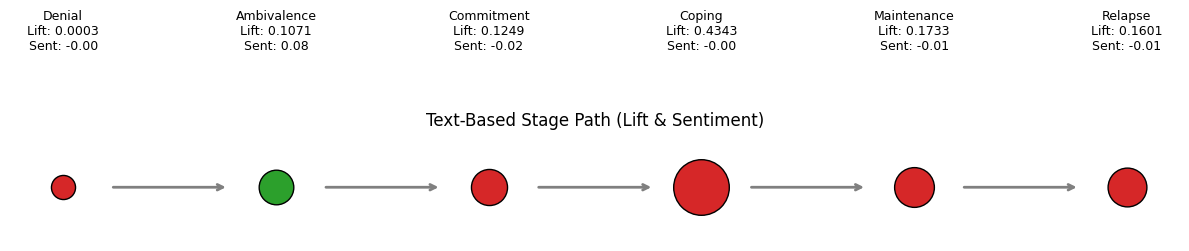

🖼️ Saved normalized stage map → results\stage_map_text_normalized.png


In [14]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt

def score_to_color(sent, pos="#2ca02c", neg="#d62728"):
    """Return color: green for positive, red for negative sentiment."""
    return pos if sent >= 0.05 else neg

fig, ax = plt.subplots(figsize=(12, 6))

# Evenly spaced node positions
x = np.linspace(0.05, 0.95, len(STAGES))
y = np.full_like(x, 0.5)

# Draw stage nodes
for i, stage in enumerate(STAGES):
    row = stage_metrics.loc[stage_metrics["stage"] == stage].iloc[0]
    color = score_to_color(row["stage_sentiment"])
    # Use normalized lift for node size
    size = 3000 * (row["stage_lift_norm"] + 0.1)  # add small offset so tiny nodes stay visible
    ax.scatter(x[i], y[i], s=size, c=color, edgecolors="black", zorder=3)
    # Label includes both raw and normalized lift values
    ax.text(
        x[i],
        y[i] + 0.08,
        f"{stage}\nLift: {row['stage_lift_norm']:.4f}\nSent: {row['stage_sentiment']:.2f}",
        ha="center",
        va="center",
        fontsize=9,
    )

# Draw sequential arrows between stages
for i in range(len(STAGES) - 1):
    ax.annotate(
        "",
        xy=(x[i + 1] - 0.04, y[i]),
        xytext=(x[i] + 0.04, y[i]),
        arrowprops=dict(arrowstyle="->", lw=2, color="gray"),
        zorder=2,
    )

ax.set_title("Text-Based Stage Path (Lift & Sentiment)")
ax.set_axis_off()
plt.tight_layout()

plot_path = OUT_DIR / "stage_map_text_normalized.png"
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"🖼️ Saved normalized stage map → {plot_path}")


## 🔹 RUNNING THE RECOMMENDER

(from Steps 14–16)

### 14) Recommender — Text Analysis + Comparison + Visualization

This unified recommender function:

1. Takes a **new transcript** (string input or uploaded file).
2. Cleans, tokenizes, and embeds it using **Word2Vec**.
3. Performs topic clustering (KMeans) and sentiment analysis (VADER).
4. Maps topics → recovery stages using **cosine similarity** (SBERT).
5. Aggregates normalized **stage lifts** and **sentiment** (sum-to-1 normalization).
6. Compares the new transcript’s stage map to the **baseline stage map**.
7. Displays:
   - 📊 A detailed comparison table.
   - 🧠 Two **mind-maps** side-by-side.
   - 📈 A **bar chart** comparing normalized lift and sentiment.

All plots are saved in the `results/` folder.


In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import nltk
from collections import Counter

nltk.download("stopwords", quiet=True)
nltk.download("vader_lexicon", quiet=True)

# --- Shared setup ---
STOPWORDS = set(stopwords.words("english"))
VADER = SentimentIntensityAnalyzer()
sbert = SentenceTransformer("all-MiniLM-L6-v2")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9.,!? ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def tokenize_clean(text):
    tokens = re.findall(r"[A-Za-z]+", text.lower())
    return [t for t in tokens if t not in STOPWORDS and len(t) > 1]

def analyze_sentiment_text(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    return VADER.polarity_scores(text)["compound"]

def score_to_color(sent, pos="#2ca02c", neg="#d62728"):
    """Green for positive, red for negative."""
    return pos if sent >= 0.05 else neg


def recommend_recovery_from_text(new_transcript: str, baseline_stage_metrics: pd.DataFrame):
    """
    Full recommender: analyze new transcript, compare with baseline, visualize results.
    Returns comparison DataFrame.
    """
    print("🧾 Processing new transcript...")

    # --- Clean & tokenize ---
    cleaned = clean_text(new_transcript)
    tokens = tokenize_clean(cleaned)

    if len(tokens) < 5:
        print("⚠️ Transcript too short for meaningful clustering.")
        return None

    # --- Word embeddings ---
    model = Word2Vec([tokens], vector_size=100, window=5, min_count=1, sg=1, epochs=10)
    vocab = list(model.wv.key_to_index.keys())
    word_vecs = np.vstack([model.wv[w] for w in vocab])

    # --- Compute raw & normalized lifts ---
    counts = Counter(tokens)
    V = len(vocab)
    total_tokens = sum(counts.values())
    word_lifts = {w: (counts[w] / total_tokens) * V for w in vocab}
    df_word = pd.DataFrame({"word": vocab, "lift": [word_lifts[w] for w in vocab]})
    df_word["lift_norm"] = minmax_scale(df_word["lift"])
    df_word["sentiment"] = df_word["word"].apply(analyze_sentiment_text)

    # --- Topic modeling (KMeans) ---
    N_TOPICS = min(6, len(vocab))
    km = KMeans(n_clusters=N_TOPICS, random_state=42, n_init=10)
    df_word["topic_id"] = km.fit_predict(word_vecs)

    # --- Aggregate topic metrics ---
    topic_agg = (
        df_word.groupby("topic_id")
        .agg(topic_lift=("lift_norm", "sum"),
             topic_sentiment=("sentiment", "mean"),
             num_words=("word", "count"))
        .reset_index()
    )
    topic_agg["topic_lift_norm"] = minmax_scale(topic_agg["topic_lift"])

    # --- Map topics → stages (cosine similarity) ---
    topic_labels_for_encoding = [
        " ".join(df_word[df_word["topic_id"] == t]["word"].tolist()) or "topic"
        for t in topic_agg["topic_id"]
    ]
    topic_sbert = sbert.encode(topic_labels_for_encoding)
    stage_texts = [STAGE_SEEDS[s] for s in STAGES]
    stage_embs = sbert.encode(stage_texts)
    S = cosine_similarity(topic_sbert, stage_embs)
    topic_to_stage = [STAGES[i] for i in S.argmax(axis=1)]

    df_topic_stage = pd.DataFrame({
        "topic_id": topic_agg["topic_id"],
        "assigned_stage": topic_to_stage,
        "topic_lift_norm": topic_agg["topic_lift_norm"],
        "topic_sentiment": topic_agg["topic_sentiment"]
    })

    # --- Stage aggregation ---
    EPSILON = 1e-3
    stage_metrics_new = (
        df_topic_stage.groupby("assigned_stage")
        .agg(stage_lift=("topic_lift_norm", "sum"),
             stage_sentiment=("topic_sentiment", "mean"))
        .reindex(STAGES, fill_value=0.0)
        .reset_index()
        .rename(columns={"assigned_stage": "stage"})
    )

    # Normalize stage lifts: sum = 1, no zeros
    stage_metrics_new["stage_lift_norm"] = stage_metrics_new["stage_lift"] + EPSILON
    stage_metrics_new["stage_lift_norm"] /= stage_metrics_new["stage_lift_norm"].sum()
    stage_metrics_new["stage_sent_label"] = np.where(
        stage_metrics_new["stage_sentiment"] >= 0.05, "positive", "negative"
    )

    print("✅ New transcript stage map created.")
    print(f"Sum of new stage_lift_norm: {stage_metrics_new['stage_lift_norm'].sum():.4f}")

    # --- Comparison table ---
    df_compare = baseline_stage_metrics[["stage", "stage_lift_norm", "stage_sentiment", "stage_sent_label"]].merge(
        stage_metrics_new[["stage", "stage_lift_norm", "stage_sentiment", "stage_sent_label"]],
        on="stage",
        suffixes=("_baseline", "_new"),
        how="outer"
    )
    df_compare["lift_diff"] = df_compare["stage_lift_norm_new"] - df_compare["stage_lift_norm_baseline"]
    df_compare["sent_diff"] = df_compare["stage_sentiment_new"] - df_compare["stage_sentiment_baseline"]

    print("\n📊 Stage-by-Stage Comparison:")
    display(df_compare)

    # --- Visualization: Side-by-Side Mind-Maps ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    for ax, stage_df, title in zip(
        axes,
        [
            baseline_stage_metrics.rename(columns={"stage_lift_norm": "lift", "stage_sentiment": "sent"}),
            stage_metrics_new.rename(columns={"stage_lift_norm": "lift", "stage_sentiment": "sent"})
        ],
        ["Baseline Stage Map", "New Transcript Stage Map"]
    ):
        G = nx.DiGraph()
        for i, s in enumerate(STAGES[:-1]):
            G.add_edge(s, STAGES[i + 1])
        pos = {s: (i, 0) for i, s in enumerate(STAGES)}
        sizes = [2500 * (row["lift"] + 0.05) for _, row in stage_df.iterrows()]
        colors = [score_to_color(row["sent"]) for _, row in stage_df.iterrows()]
        nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors,
                               edgecolors="black", ax=ax)
        nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->",
                               width=2, alpha=0.6, ax=ax)
        nx.draw_networkx_labels(
            G, pos,
            labels={
                row["stage"]: f"{row['stage']}\nLift:{row['lift']:.4f}\nSent:{row['sent']:.2f}"
                for _, row in stage_df.iterrows()
            },
            font_size=9, ax=ax
        )
        ax.set_title(title, fontsize=13, fontweight="bold")
        ax.axis("off")

    plt.tight_layout()
    map_path = OUT_DIR / "comparison_stage_maps.png"
    plt.savefig(map_path, dpi=300)
    plt.show()
    print(f"🖼️ Saved side-by-side stage maps → {map_path}")

    # --- Visualization: Enhanced Bar Chart ---
    fig, ax1 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # 1️⃣ Normalized Lift Comparison
    ax1[0].bar(df_compare["stage"], df_compare["stage_lift_norm_baseline"],
               width=0.4, label="Baseline", align="center", color="#1f77b4")
    ax1[0].bar(df_compare["stage"], df_compare["stage_lift_norm_new"],
               width=0.4, label="New Transcript", align="edge", color="#ff7f0e")
    ax1[0].set_ylabel("Normalized Lift (sum=1)", fontsize=12)
    ax1[0].set_title("Normalized Stage Lifts", fontsize=14, fontweight="bold")
    ax1[0].legend(fontsize=10)
    ax1[0].tick_params(axis='y', labelsize=11)
    ax1[0].set_ylim(0, 1.1)

    # 2️⃣ Sentiment Comparison
    ax1[1].bar(df_compare["stage"], df_compare["stage_sentiment_baseline"],
               width=0.4, label="Baseline", align="center", color="#1f77b4")
    ax1[1].bar(df_compare["stage"], df_compare["stage_sentiment_new"],
               width=0.4, label="New Transcript", align="edge", color="#ff7f0e")
    ax1[1].axhline(0, color="gray", lw=0.8)
    ax1[1].set_ylabel("Sentiment Score", fontsize=12)
    ax1[1].set_title("Average Stage Sentiment", fontsize=14, fontweight="bold")
    ax1[1].legend(fontsize=10)
    ax1[1].tick_params(axis='y', labelsize=11)
    ax1[1].set_ylim(-0.2, 0.3)

    # Common settings
    plt.xticks(rotation=45, fontsize=11)
    plt.tight_layout()
    bar_path = OUT_DIR / "comparison_bar_chart.png"
    plt.savefig(bar_path, dpi=300)
    plt.show()
    print(f"📊 Saved bar chart comparison → {bar_path}")

    return df_compare


### 15) Example Run — Recommender

This cell runs the recommender on a new transcript.
It will print the stage-by-stage comparison table and display both
the mind-map and bar-chart visualizations.


🧾 Processing new transcript...
✅ New transcript stage map created.
Sum of new stage_lift_norm: 1.0000

📊 Stage-by-Stage Comparison:


,stage,stage_lift_norm_baseline,stage_sentiment_baseline,stage_sent_label_baseline,stage_lift_norm_new,stage_sentiment_new,stage_sent_label_new,lift_diff,sent_diff
0,Ambivalence,0.107124,0.083506,positive,0.000994,0.000000,negative,-0.106129,-0.083506
1,Commitment,0.124921,-0.021814,negative,0.995030,0.200950,positive,0.870109,0.222764
2,Coping,0.434252,-0.001331,negative,0.000994,-0.009390,negative,-0.433258,-0.008059
3,Denial,0.000338,-0.003246,negative,0.000994,0.000000,negative,0.000656,0.003246
4,Maintenance,0.173284,-0.011373,negative,0.000994,0.105375,positive,-0.172290,0.116748
5,Relapse,0.160081,-0.007067,negative,0.000994,0.000000,negative,-0.159087,0.007067


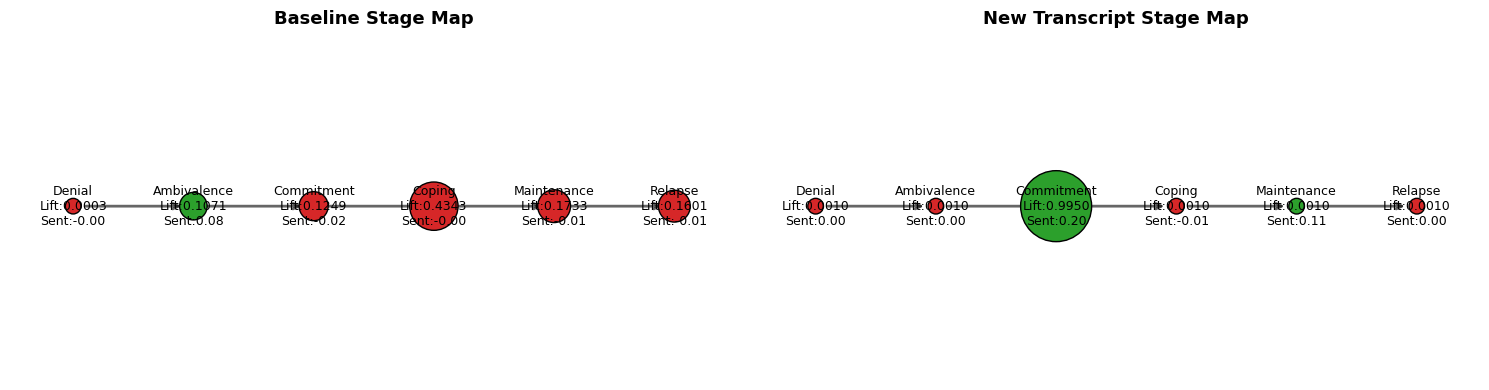

🖼️ Saved side-by-side stage maps → results\comparison_stage_maps.png


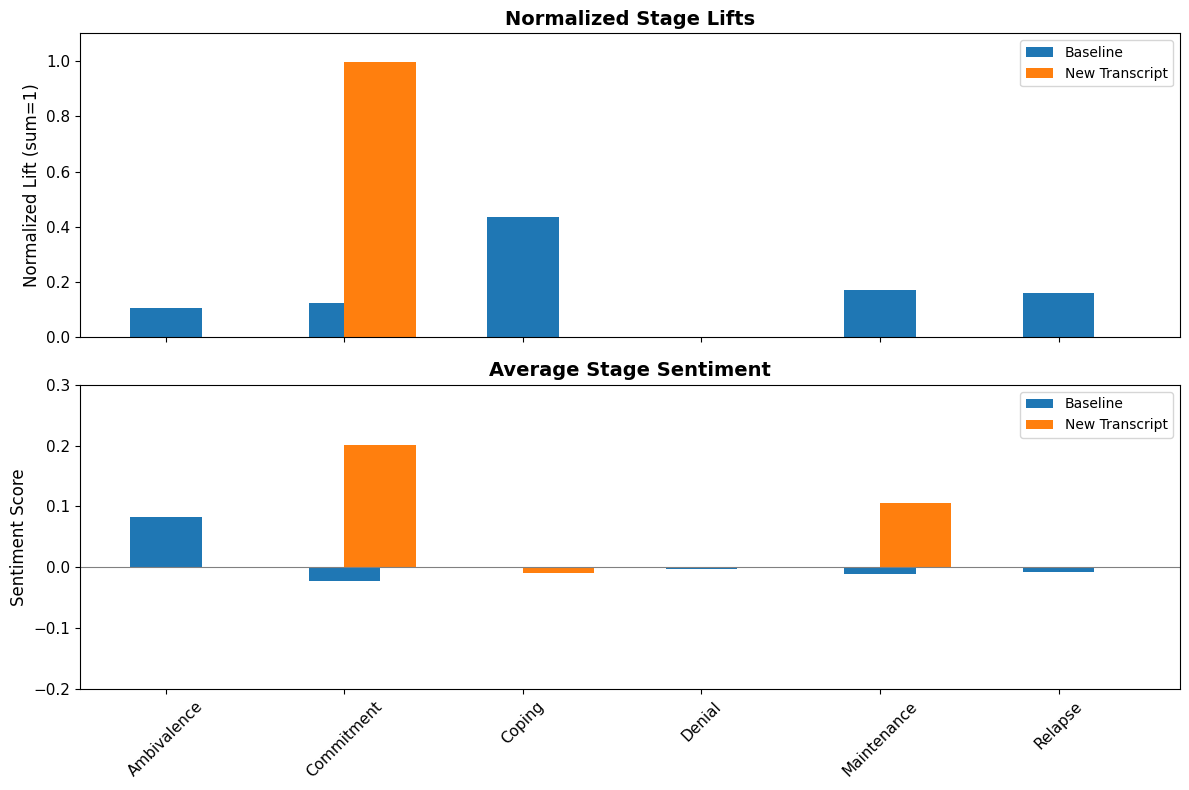

📊 Saved bar chart comparison → results\comparison_bar_chart.png


In [16]:
# Example: Inline new transcript
new_text = """
At first I didn’t think I needed any help. Eventually, I realized my habits were hurting me deeply.
After seeking help, I began attending group sessions and felt hope again.
Now I focus on daily coping strategies and mindfulness to maintain my progress.
"""

comparison_table = recommend_recovery_from_text(new_text, stage_metrics)


### 16) Upload & Analyze a Transcript File

This cell asks the full path of a `.txt` file containing a transcript.  
The selected file is automatically read and passed into the unified recommender function to generate the full stage-by-stage comparison, visualizations, and saved results.


> **THE BELOW CELL SHOULD BE UNCOMMENTED AND RUN ONLY IF THERE IS AN APPROPRIATE TEXT FILE AVAILABLE**  


🔍 Preview of uploaded transcript:
When I first started using, I told myself I had complete control. I thought I could stop anytime I wanted, but the truth was I couldn’t. For a long time, I denied that I had a problem. My family tried to talk to me, but I pushed them away, convinced that I was fine. Eventually, things got worse. I l...

🚀 Running recommender analysis...
🧾 Processing new transcript...
✅ New transcript stage map created.
Sum of new stage_lift_norm: 1.0000

📊 Stage-by-Stage Comparison:


,stage,stage_lift_norm_baseline,stage_sentiment_baseline,stage_sent_label_baseline,stage_lift_norm_new,stage_sentiment_new,stage_sent_label_new,lift_diff,sent_diff
0,Ambivalence,0.107124,0.083506,positive,0.000427,0.000000,negative,-0.106696,-0.083506
1,Commitment,0.124921,-0.021814,negative,0.712881,0.008978,negative,0.587960,0.030792
2,Coping,0.434252,-0.001331,negative,0.285409,0.089831,positive,-0.148843,0.091162
3,Denial,0.000338,-0.003246,negative,0.000427,0.000000,negative,0.000090,0.003246
4,Maintenance,0.173284,-0.011373,negative,0.000427,0.000000,negative,-0.172857,0.011373
5,Relapse,0.160081,-0.007067,negative,0.000427,0.000000,negative,-0.159654,0.007067


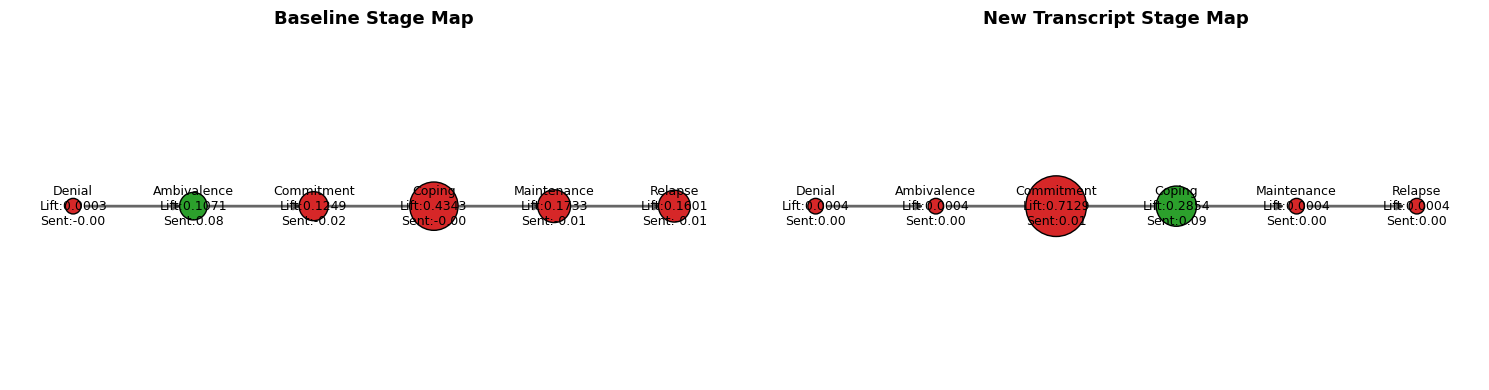

🖼️ Saved side-by-side stage maps → results\comparison_stage_maps.png


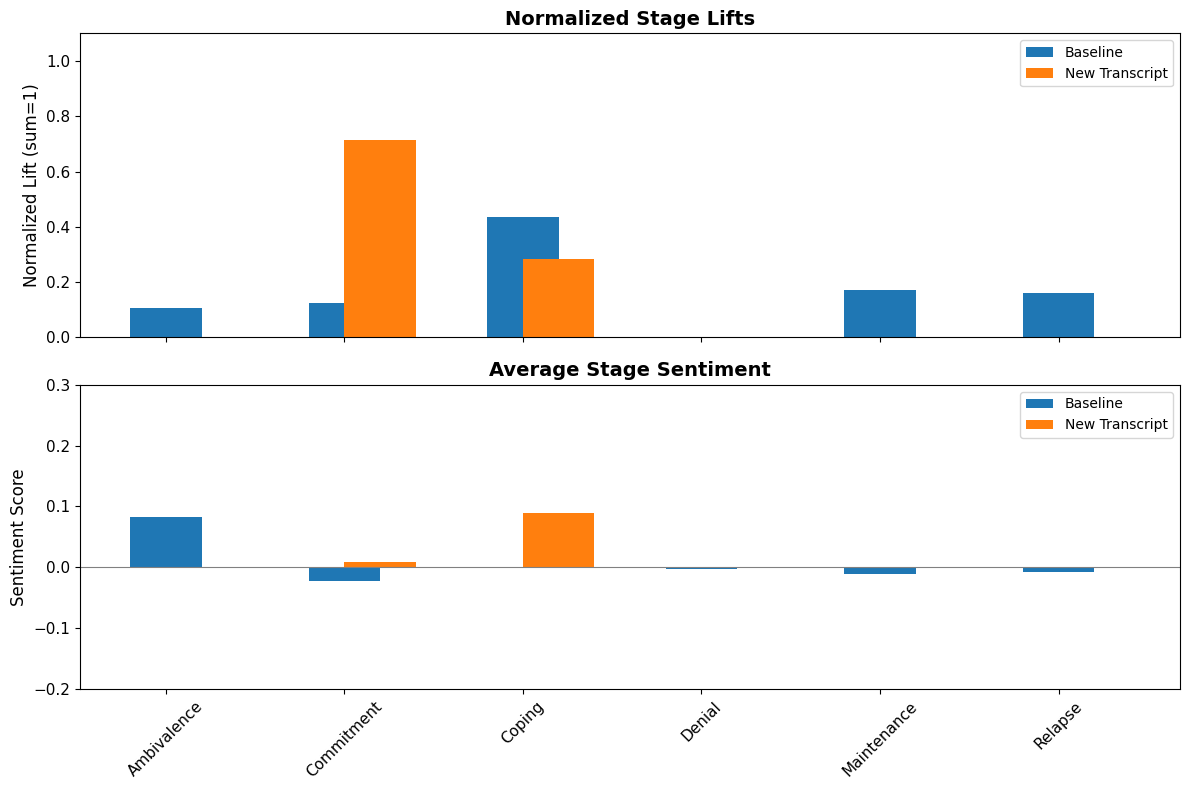

📊 Saved bar chart comparison → results\comparison_bar_chart.png


In [ ]:
# file_path = input("📂 Enter full path to transcript .txt file: ").strip().strip('"')

# if file_path and file_path.endswith(".txt"):
#     with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
#         new_text = f.read()
#     print("\n🔍 Preview of uploaded transcript:")
#     print(new_text[:300] + ("..." if len(new_text) > 300 else ""))
#     print("\n🚀 Running recommender analysis...")
#     comparison_table = recommend_recovery_from_text(new_text, stage_metrics)
# else:
#     print("❌ Invalid file path or file not selected.")


---
# THE END